# <img src="./assets/course-icon.png" style="height:50px;display:inline"> EE 046211 - Technion - Deep Learning
---

#### Tal Daniel

## Tutorial 07 - Sequential Tasks - Recurrent Neural Networks
---
<img src="./assets/rnn_1.jpg" style="height:200px">

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Natural Language Processing and Sequences](#-Natural-Language-Processing-and-Sequences)
* [Text Preprocessing](#-Text-Preprocessing)
* [Evaluation in NLP - Perplexity and BLEU](#-Evaluation-in-NLP---Perplexity-and-BLEU)
* [Recurrent Neural Networks (RNNs)](#-Recurrent-Neural-Networks-(RNNs))
* [Backpropagation Through Time (BPTT)](#-Backpropagation-Through-Time-(BPTT))
* [Long Term Short Memory (LSTM)](#-Long-Term-Short-Memory-(LSTM))
* [Gated Recurrent Unit (GRU)](#-Gated-Recurrent-Unit-(GRU))
* [Attention](#-Attention)
* [The Transformer](#-The-Transformer)
* [Pretrained Models - BERT and GPT](#-Pretrained-Models---BERT-and-GPT)
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

In [43]:
# imports for the tutorial
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# pytorch
import torch
import torch.nn as nn
import torchtext
import torchtext.data as data
import torchtext.datasets as datasets
import torch.nn.functional as f

## <img src="https://img.icons8.com/nolan/64/language.png" style="height:50px;display:inline"> Natural Language Processing and Sequences
---
* So far we have dealt with tabular data and images, but what about text or sequences?
* Sequence modeling is the field of modeling sequences, e.g., text sentences, videos, stocks rate, trajectories in reinforcement learning or autonomous driving, wheather forecast and etc...
* Unlike our previous assumption that the data we have is i.i.d., this is not usually the case in sequences (e.g., if you randomly change the words in a sentence, it would be very hard to understand its meaning).
* We will focus on text data in the field of natural language processing (NLP).

#### Language Models
---
* Language models assign a probability to a text: $p(x_0, \cdots, x_n)$
* The most popular method is to factorize distribution using the basic probability principles and the Markovian assumption: $$p(x_0, \cdots, x_n) = p(x_0)p(x_1|x_0)\cdots p(x_n|x_{n-1})$$
* However, this approach makes many assumptions that are unecessarily true (e.g. Markovian assumption -  dependency only on the previous word and not the entire history). 

<img src="./assets/lang_model.gif" style="height:250px">

* <a href="https://medium.com/perceptronai/recurrent-neural-network-an-introduction-for-beginners-1c13a541c906">Image Source</a>

#### Neural Language Models
---
* There are classical ways to build a language models, but the focus of this course is deep learning, so we will leave the classical approaches to the various NLP courses.
* **Embeddings**: Basically we input the text into a neural network, the neural network will map all this context onto a vector. This vector represents the next word and we have some big word embedding matrix. The word embedding matrix contains a vector for every possible word the model can output.
* The first neural language models were convolutional-based (1D):
    * Embed each word as a vector, which is a lookup table to the embedding matrix, so the word will get the same vector no matter what context it appears in.
    * Apply same feed forward network at each time step.
    * Unfortunately, fixed length history means it can only condition on bounded context, but these models are very fast!

<img src="./assets/lang_model_conv.jpg" style="height:300px">

#### Forms of Sequence Prediction Tasks
---
* **One-to-one**: from fixed-sized input to fixed-sized output (e.g. image classification).
* **One-to-many**: Sequence output (e.g. image captioning takes an image and outputs a sentence of words).
* **Many-to-one**: Sequence input (e.g. sentiment analysis where a given sentence is classified as expressing positive or negative sentiment or given some text predict the next character)
* **Many-to-many**: Sequence input and sequence output (e.g. Machine Translation).
* **Many-to-many**: Synced sequence input and output (e.g. video classification where we wish to label each frame of the video).

<img src="./assets/seq_tasks.jpeg" style="height:250px">

* <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">Image Source</a>

## <img src="https://img.icons8.com/bubbles/50/000000/connection-sync.png" style="height:50px;display:inline"> Text Preprocessing
---
* Before we dive into the specific models, we need to understand how to process text data, as you can't just feed words to neural networks, but you need to give them some numerical representation.
* The general steps are:
    * Load text as strings into memory.
    * **Tokenization**: Split strings into tokens (e.g., words and characters).
    * **Vocabulary**: Build a table of vocabulary to map the split tokens to numerical indices.
    * Convert text into sequences of numerical indices so they can be manipulated by models easily.
* We will use `torchtext`, the official PyTorch library to handle text data.
* We use the IMDB dataset: this dataset contains movie reviews which are labeled as `positive` and `negative` (for good and bad reviews, respectively).
    * This task is called **sentiment analysis** in NLP, and it is essentially a classification task.
* If you want to load other datasets or load a custom dataset: https://torchtext.readthedocs.io/en/latest/datasets.html
* **Special tokens**:
    * `<sos>` - token that marks the start of a sentence.
    * `<pad>` - token that is used to pad sentences that are shorter than the longest sentence in a batch.
    * `<eos>` - token that marks the end of a sentence.
    * `<unk>` - token that marks unknown words (e.g., if the model thinks that no word in the vocabulary is good as next word)

In [2]:
max_len = 200  # max length of a sequence
# define a text field
text = data.Field(sequential=True, fix_length=max_len, batch_first=True, lower=True, dtype=torch.long)
# define a label field
label = data.LabelField(sequential=False, dtype=torch.long)
# uncomment the following to download the imdb dataset
# datasets.IMDB.download('./datasets')
# split to train and test
ds_train, ds_test = datasets.IMDB.splits(text, label, path='./datasets/imdb/aclImdb/')
# if you want to load a custom text dataset, you can take a look at how `datasets.IMDB` is implemented
print('train : ', len(ds_train))
print('test : ', len(ds_test))
print('train.fields :', ds_train.fields)

train :  25000
test :  25000
train.fields : {'text': <torchtext.data.field.Field object at 0x000001D618D55748>, 'label': <torchtext.data.field.LabelField object at 0x000001D618D55780>}


In [3]:
# further split to train and validation
ds_train, ds_valid = ds_train.split(0.9)
print('train : ', len(ds_train))
print('valid : ', len(ds_valid))
print('test : ', len(ds_test))

train :  22500
valid :  2500
test :  25000


In [4]:
# build a vocabulary
num_words = 50_000  # a fancy way to write 50,000
text.build_vocab(ds_train, max_size=num_words)
label.build_vocab(ds_train)
vocab = text.vocab

In [5]:
# let's see what is the token assigned for 'what'
print("the token of 'what':", vocab.stoi['what'])
# let's see what is the token number 27
print("token number 27 is:", vocab.itos[27])
# special tokens
print("special tokens:")
print("<pad>: ", vocab.stoi['<pad>'])
print("<unk>: ", vocab.stoi['<eos>'])
# note that <sos> and <eos> should be added manually

the token of 'what': 48
token number 27 is: he
special tokens:
<pad>:  1
<unk>:  0


In [6]:
batch_size = 1
train_loader, valid_loader, test_loader = data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=batch_size, sort_key=lambda x: len(x.text), repeat=False)
sample = next(iter(train_loader))
print("tokens: ")
print(sample.text)
print("text: ", " ".join([vocab.itos[t] for t in sample.text[0].data.cpu().numpy()]))
print("label: ")
print(sample.label)

tokens: 
tensor([[  219, 30744,     7,    32,   944,     6,    90,     3,  1059,  9228,
           174,  9177,   576,     5,    76,    17,    32,  7545,     4,     3,
             0,   281,    12,   175,     6,   210,    29,    12,    31,   108,
             5, 20656,    40, 33312,  3766,     0,     2,   118,    22,  2673,
             4,  4853,    15,    22,     2,   991,     4,   131,  3841,     2,
            20,   175,  3358,   187, 10584,     4,  7792,    19,     2,    30,
           816,    52,     7,     3,  3322,   944,    29,    99,  2673,    15,
          1124,    30,   697,     5, 24608,    45,  1337,   118,    54,  1002,
          1349,    11,  7401,  1330,     5,  3029,    72,     2,  5407,    29,
          1543,     4,    73,  3275,  2114,  8343,  1073,   196,     6,    90,
             3,  4561,    16,     3,  6039,   375,     2, 48589,    86,    73,
             0,   665,     2,   562,  7753,     5,   129,     3,  2489,    44,
            39,    30,     5,   101, 22670,

### <img src="https://img.icons8.com/dusk/64/000000/translate-app.png" style="height:50px;display:inline"> Evaluation in NLP - Perplexity and BLEU
---
#### Perplexity
---
**Perplexity** measures the language model quality. **A better language model should allow us to predict the next token more accurately**. Thus, it should allow us to spend fewer bits in compressing the sequence. We can measure it by the cross-entropy loss averaged over all the $n$ tokens of a sequence: $$ \frac{1}{n}\sum_{i=1}^n -\log P(x_t|x_{t-1}, ..., x_1), $$ where $P$ is given by the language model and $x_t$ is the actual token observed at time step $t$ from the sequence. The **perplexity** is defined as $$ \exp\left(\frac{1}{n}\sum_{i=1}^n -\log P(x_t|x_{t-1}, ..., x_1)\right). $$
* Perplexity can be best understood as the harmonic mean of the number of real choices that we have when deciding which token to pick next. 
* In the **best** case scenario, the model always perfectly estimates the probability of the label token as 1. **In this case the perplexity of the model is 1**.
* In the **worst** case scenario, the model always predicts the probability of the label token as 0. In this situation, the perplexity is **positive infinity**.
* At the **baseline**, the model predicts a uniform distribution over all the available tokens of the vocabulary. In this case, the perplexity equals the number of unique tokens of the vocabulary.
    *  In fact, if we were to store the sequence without any compression, this would be the best we could do to encode it. Hence, this provides a nontrivial upper bound that any useful model must beat.

#### Bilingual Evaluation Understudy (BLEU) Score
---
* **BLEU** score is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another.
* Scores are calculated for individual translated segments—generally sentences—by comparing them with a set of good quality reference translations. 
* Those scores are then averaged over the whole corpus to reach an estimate of the translation's overall quality. 
* **Intelligibility or grammatical correctness are not taken into account**.
* BLEU's output is always a number between 0 and 1. 
* This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts.
    * Few human translations will attain a score of 1, since this would indicate that the candidate is identical to one of the reference translations. 
    * For this reason, it is not necessary to attain a score of 1. Because there are more opportunities to match, adding additional reference translations will increase the BLEU score.
* BLEU uses a modified version of the precision score between a candidate translation and translation ground-truth (it is better to provide more than one reference), and it is based on $n$-grams.
* <a href="https://en.wikipedia.org/wiki/BLEU">Read More</a>

## <img src="https://img.icons8.com/nolan/64/re-enter-pincode.png" style="height:50px;display:inline"> Recurrent Neural Networks (RNNs)
---
* The idea of **Recurrent Neural Networks (RNNs)**: save the output of a particular layer and feed it back to the input in order to predict the output of the layer.
* Every time step we maintain some state (received from the previous time step)--**hidden state**, which represents what we’ve read so far. This is combined with current word being read and used at later state. Then we repeat this process for as many time steps as we need.

<img src="./assets/rnn_2.gif" style="height:200px">

* <a href="https://medium.com/perceptronai/recurrent-neural-network-an-introduction-for-beginners-1c13a541c906">Image Source</a>

* Let $x$ denote the input layer, $h$ the hidden layer and $y$ the output layer.
* Let $A, B \text{ and } C$ be some network parameters used to improve the output of the model.
* At any given time $t$, the current input is a combination of the input at $x(t)$ and $x(t-1)$ (through $h(t-1)$).

<img src="./assets/rnn_3.gif" style="height:250px">

* <a href="https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn">Image Source</a>

#### The Hidden State of RNN Cells
---
* For each element in the input sequence, each layer computes the following function: $$ h_t = tanh\left(W_{ih}x_t +b_{ih} + W_{hh}h_{(t-1)} + b_{hh}\right), $$ where $h_t$ is the hidden state at time $t$, $x_t$ is the input at time $t$, and $h_{(t-1)}$ is the hidden state of the previous layer at time $t-1$ or the initial hidden state at time 0.

<img src="./assets/rnn_4.gif" style="height:250px">

* Image by Michael Nguyen

* In PyTorch: <a href="https://pytorch.org/docs/stable/generated/torch.nn.RNN.html">`torch.nn.RNN(input_size, hidden_size, num_layers...)`</a>

#### Disadvantages of RNNs
---
* The whole history of the document reading is compressed into fixed-size vector at each time step, which is the bottleneck of this model.
* **Gradients tend to vanish** with long contexts.
* Not possible to parallelize over time-steps, so **slow training**.

### <img src="https://img.icons8.com/nolan/64/time-machine.png" style="height:50px;display:inline"> Backpropagation Through Time (BPTT)
---
* **Forward propagation** in an RNN is relatively straightforward and is the same as MLPs.
* **Backpropagation through time (BPTT)**: a specific application of backpropagation in RNNs. 
* BPTT requires us to expand or *unroll* the computational graph of an RNN one time step at a time to obtain the dependencies among model variables and parameters.
* Then, based on the chain rule, we apply backpropagation to compute and store gradients. 
    * Since sequences can be rather long, the dependency can be rather lengthy. 
    * For instance, for a sequence of 1000 characters, the first token could potentially have significant influence on the token at the final position. This is not really computationally feasible (it takes too long and requires too much memory) and it requires over 1000 matrix products before we would arrive at that very elusive gradient.
* High powers of matrices can lead to **divergent or vanishing eigenvalues -- exploding or vanishing gradients**.
* For efficient computation, **intermediate values are cached** during backpropagation through time.

#### Computing Gradients in BPTT
---
* Consider an RNN *without* bias parameters, whose activation function in the hidden layer uses the identity mapping ( $\phi(x)=x$ ). 
* For time step $t$ , let the single example input and the label be $x_t\in \mathbb{R}^d$ and $y_t$ , respectively.
* The hidden state  $h_t\in \mathbb{R}^h$  and the output $o_t\in \mathbb{R}^q$  are computed as: $$ h_t=W_{hx}x_t+W_{hh}h_{t−1}, $$ $$ o_t = W_{qh}h_t, $$ where $W_{hx}\in \mathbb{R}^{h\times d}$,  $W_{hh}\in \mathbb{R}^{h\times h}$, and $W_{qh}\in \mathbb{R}^{q\times h}$ are the weight parameters.
* Denote by $l(o_t,y_t)$ the loss at time step $t$. Our objective function, the loss over $T$ time steps from the beginning of the sequence is thus: $$ L = \frac{1}{T}\sum_{t=1}^T l(o_t,y_t).$$

* Computational graph for 3 time steps:

<img src="./assets/bptt_1.svg" style="height:250px">

* For example, the computation of the hidden states of time step 3,  $h_3$ , depends on the model parameters $W_{hx}$ and $W_{hh}$, the hidden state of the last time step $h_2$, and the input of the current time step $x_3$.

* According to the dependencies in the graph, we can traverse in the opposite direction of the arrows to calculate and store the gradients in turn. We can look at this as unrolled backpropagation.
* Differentiating the objective function with respect to the model output at any time step $t$ is straightforward: $$ \frac{\partial L}{\partial o_t} = \frac{\partial l(o_t, y_t)}{T\cdot \partial o_t} \in \mathbb{R}^q.$$
* Now, we can calculate the gradient of the objective function with respect to the parameter $W_{qh}$ in the output layer. Note that the objective function $L$ depends on $W_{qh}$ via $o_1,…,o_T$: $$ \frac{\partial L}{\partial W_{qh}}=\sum_{t=1}^T \text{prod} \left(\frac{\partial L}{\partial o_t}, \frac{\partial o_t}{\partial W_{qh}} \right) = \sum_{t=1}^T \frac{\partial L}{\partial o_t}h_t^T $$

* We continue back down the graph, and we need the derivatives w.r.t $h_t$.
* At the final time step $T$ the objective function $L$ depends on the hidden state $h_T$ only via $o_T$: $$ \frac{\partial L}{\partial h_T} = \text{prod}\left(\frac{\partial L}{\partial o_T}, \frac{\partial o_T}{\partial h_T} \right) = W_{qh}^T \frac{\partial L}{\partial o_T}\in \mathbb{R}^h. $$
* It gets trickier for any time step $t<T$, where the objective function $L$ depends on $h_t$ via $h_{t+1}$ and $o_t$. According to the chain rule: $$\frac{\partial L}{\partial h_t} = \text{prod}\left(\frac{\partial L}{\partial h_{t+1}}, \frac{\partial h_{t+1}}{\partial h_t} \right) + \text{prod}\left(\frac{\partial L}{\partial o_t}, \frac{\partial o_t}{\partial h_t} \right) = W_{hh}^T\frac{\partial L}{\partial h_{t+1}} + W_{qh}^T\frac{\partial L}{\partial o_t}. $$
* (EXERCISE) Expanding the recurrent computation for any time step $1\leq t \leq T$ gives: $$ \frac{\partial L}{\partial h_t} = \sum_{i=t}^T \left(W_{hh}^T \right)^{T-i}W_{qh}^T\frac{\partial L}{\partial o_{T+t-i}} $$

* Notice that the simple linear equation already exhibits some key problems of long sequence models: it involves potentially very large powers of $W_{hh}^T$. 
* In it, eigenvalues smaller than 1 **vanish** and eigenvalues larger than 1 **diverge**. This is numerically unstable, which manifests itself in the form of **vanishing and exploding gradients**. 
* One way to address this is to truncate the time steps at a computationally convenient size. In practice, this truncation is effected by detaching the gradient after a given number of time steps.
* GRUs and LSTMs cells can alleviate this better as we will soon see.

* Finally, the objective function $L$ depends on model parameters $W_{hx}$ and $W_{hh}$ in the hidden layer via hidden states  $h_1,…,h_T$: $$ \frac{\partial L}{\partial W_{hx}} = \sum_{i=t}^T \text{prod}\left(\frac{\partial L}{\partial h_t}, \frac{\partial h_t}{\partial W_{hx}} \right) = \sum_{i=t}^T \frac{\partial L}{\partial h_t}x_t^T, $$
$$ \frac{\partial L}{\partial W_{hx}} = \sum_{i=t}^T \text{prod}\left(\frac{\partial L}{\partial h_t}, \frac{\partial h_t}{\partial W_{hh}} \right) = \sum_{i=t}^T \frac{\partial L}{\partial h_t}h_{t-1}^T$$

* BPTT computes and stores the above gradients in turn. Specifically, stored intermediate values are reused to avoid duplicate calculations, such as storing  $\frac{\partial L}{\partial h_t}$ to be used in computation of both $\frac{\partial L}{\partial W_{hx}}$ and $\frac{\partial L}{\partial W_{hh}}$.

### <img src="https://img.icons8.com/dusk/64/000000/memory-slot.png" style="height:50px;display:inline"> Long Term Short Memory (LSTM)
---
* As mentioned before, during backpropagation, RNNs suffer from the vanishing gradient problem, which essentially creates a **short memory**.
* Long short-term memory (LSTM) is a type of recurrent cell that tries to preserve long term information. The idea of LSTM was presented back in 1997, but flourished in the age of deep learning.
* LSTM introduces a memory cell that has the same shape as the hidden state, engineered to record additional information.
* The memory is controlled by 3 main gates: 
    * **Input gate**: decides when to read data into the cell.
    * **Output gate**: outputs the entries from the cell.
    * **Forget gate**: a mechanism to reset the content of the cell.
* These gates learn which information is relevant to forget or remember during the training process. The gates contain a sigmoid activation function.

<img src="./assets/lstm_1.svg" style="height:250px">

* Suppose that there are $h$ hidden units, the batch size is $n$, and the number of inputs is $d$. Thus, the input is $X_t\in \mathbb{R}^{n\times d}$ (number of examples: $n$, number of inputs: $d$) and the hidden state of the previous time step is $H_{t-1}\in\mathbb{R}^{n\times h}$ (number of hidden units: $h$). We define the following at timestep $t$:
    * **Input gate**: $$ I_t = \sigma(X_tW_{xi} +H_{t-1}W_{hi} +b_i) \in \mathbb{R}^{n\times h},$$
    * **Forget gate**: $$ F_t = \sigma(X_tW_{xf} +H_{t-1}W_{hf} +b_f) \in \mathbb{R}^{n\times f}, $$
    * **Output gate**: $$ O_t = \sigma(X_tW_{xo} +H_{t-1}W_{ho} +b_o) \in \mathbb{R}^{n\times o}, $$

#### Memory Cell
---
* The candidate memory cell $\tilde{C}_t$ is defined as follows: $$ \tilde{C}_t = \text{tanh}(X_tW_{xc} +H_{t-1}W_{hc} +b_c) \in \mathbb{R}^{n\times c}$$
    * Note the difference in notations: a candidate memory is denoted with $\tilde{\cdot}$ while the actual memory is without the tilde.
* The input gate $I_t$ governs how much we take new data into account via $\tilde{C}_t$ and the forget gate $F_t$ addresses how much of the old memory cell content $C_{t-1}$ we retain. This yields: $$ C_t = F_t \odot C_{t-1} + I_{t} \odot \tilde{C}_t$$
    * $\odot$ is the element-wise product operator (Hadamard).
* If the forget gate is always approximately 1 and the input gate is always approximately 0, the past memory cells $C_{t-1}$ will be saved over time and passed to the current time step. 
* This design is introduced to alleviate the vanishing gradient problem and to better capture long range dependencies within sequences.
* Finally, the hidden state at time $t$: $$ H_t = O_t \odot \text{tanh}(C_t).$$

<img src="./assets/lstm_2.gif" style="height:350px">

* <a href="https://becominghuman.ai/long-short-term-memory-part-1-3caca9889bbc">Image Source</a>

In [3]:
rnn = nn.LSTM(input_size=10, hidden_size=20, num_layers=2)
x = torch.randn(5, 3, 10)  # 5 words per senetence, 3 sentences (batch_size), embedding dimension of each word is 10
h0 = torch.randn(2, 3, 20)  # initialize hidden states per layer
c0 = torch.randn(2, 3, 20)  # initialize memory per layer
output, (hn, cn) = rnn(x, (h0, c0))
print(f'shapes: output - {output.shape}, hidden - {hn.shape}, memory - {cn.shape}')

shapes: output - torch.Size([5, 3, 20]), hidden - torch.Size([2, 3, 20]), memory - torch.Size([2, 3, 20])


### <img src="https://img.icons8.com/color/96/000000/front-gate-open.png" style="height:50px;display:inline"> Gated Recurrent Unit (GRU)
---
* Unlike regular RNNs, Gated Recurrent Units (GRUs) support gating of the hidden state.
* GRUs have two mechanism to control when a hidden state should be updated, **update gate** and also when it should be reset, **reset gate**.
* **Reset gate**: allows to control how much of the previous state should be remembered, helps capture short-term dependencies in sequences.
* **Update gate**: allows to control how much of the new state is just a copy of the old state, help capture long-term dependencies in sequences.
* Unlike LSTMS, GRUs don't have a memory componenet, and thus are much faster to update (which results in faster training), but usually LSTMs perform better.

<img src="./assets/gru_1.svg" style="height:300px">

* Suppose that the input is a mini-batch $X_t \in \mathbb{R}^{n\times d}$ for a given time step $t$ and the hidden state of the previous time step is $H_{t−1}\in \mathbb{R}^{n\times h}$.
* The reset gate $R_t \in \mathbb{R}^{n \times h}$ and update gate $Z_t \in \mathbb{R}^{n \times h}$ are computed as follows: $$ R_t = \sigma(X_tW_{xr} + H_{t-1}W_{hr} +b_r), $$ $$ Z_t = \sigma(X_tW_{xz} + H_{t-1}W_{hz} +b_z), $$ where $W_{xr}, W_{xz} \in \mathbb{R}^{d \times h}$ and $W_{hr}, W_{hz} \in \mathbb{R}^{h \times h}$ are weight parameters, and $b_r, b_z \in \mathbb{R}^{1 \times h}$ are biases.

#### GRUs Hidden State
---
* The *candidate* hidden state $\tilde{H}_{t} \in \mathbb{R}^{n \times h}$ at timestep $t$ is defined as: $$ \tilde{H}_{t} = \text{tanh}\left(X_t W_{xh} + (R_t \odot H_{t-1})W_{hh} \right) + b_h$$
    * The result is a candidate since we still need to incorporate the action of the *update gate*.
* Finally, the new hidden state $H_t$ and the final update to the GRU in timestep $t$: $$ H_t = Z_t \odot H_{t-1} +(1-Z_t) \odot \tilde{H}_t. $$
* Whenever the update gate $Z_t$ is close to 1, we simply retain the old state. In this case the information from $X_t$ is essentially ignored, effectively skipping time step $t$ in the dependency chain. 
* In contrast, whenever $Z_t$ is close to 0, the new latent state $H_t$ approaches the candidate latent state $\tilde{H}_t$.
* These designs can help us cope with the vanishing gradient problem in RNNs and better capture dependencies for sequences with large time step distances.

In [2]:
rnn = nn.GRU(input_size=10, hidden_size=20, num_layers=2)  
x = torch.randn(5, 3, 10)  # 5 words per senetence, 3 sentences (batch_size), embedding dimension of each word is 10
h0 = torch.randn(2, 3, 20)  # initialize hidden states per layer
output, hn = rnn(x, h0)
print(f'shapes: output - {output.shape}, hidden - {hn.shape}')

shapes: output - torch.Size([5, 3, 20]), hidden - torch.Size([2, 3, 20])


## <img src="https://img.icons8.com/cute-clipart/64/000000/alarm.png" style="height:50px;display:inline"> Attention
---
* **Attention** is a generalized pooling method with bias alignment over inputs. 
* An input of the attention layer is called a **query**. 
* For a query, attention returns an output based on the memory — a set of **key-value** pairs encoded in the attention layer.
* There are two main types of attention: **self-attention** and **cross-attention**, and in each type we can define **hard** attention or **soft** attention.
* Our foucs will be **self-attention**.

* Consider a set of $t$ input $x$'s, where $x_i \in \mathbb{R}^n$. This set can be represented as the matrix $X \in \mathbb{R}^{n \times t}$.
* In self-attention, we define the hidden representation $h$ as a linear combination of the inputs: $$ h = \alpha_1 x_1 +...\alpha_t x_t $$
* Using the matrix representation described above, and stacking all the $\alpha$'s is a vector $a \in \mathbb{R}^{t}$ we can write the hidden layer as the matrix product: $ h=Xa \in \mathbb{R}^n $
* Depending on the constraints we impose on the vector $a$, we can achieve hard or soft attention.
* **Hard attention**: we impose the following constraint on the alphas: $||a||_0=1$, which means that $a$ is a one-hot vector. That is the hidden representation reduces to the input $x_i$ corresponding to the element $\alpha_i=1$.
* **Soft attention**: With soft attention, we impose that $||a||_1=1$. The hidden representations is a linear combination of the inputs where the coefficients sum up to 1.

#### Obtaining $\alpha_i$'s
---
* **Hard attention**: $$a = \text{argmax}(X^Tx_i) \in \mathbb{R}^t $$
    * We get a one-hot vector of alphas.
* **Soft attention**: $$ a = \text{soft(arg)max}(X^Tx_i) \in \mathbb{R}^t  $$
    * The components of the resulting vector $a$ sum to 1.
* The components of the vector $a$ are also called “scores” because the scalar product between two vectors tells us how aligned or similar two vectors are. 
* Therefore, the elements of $a$ provide information about the similarity of the overall set to a particular $x_i$.
* Generating $a$ this way gives a set of them, one for each $x_i$. Moreover, each $a_i \in \mathbb{R}^t$ so we can stack the alphas in a matrix $A \in \mathbb{R}^{t \times t}$.
* Since each hidden state is a linear combination of the inputs $X$ and a vector $a$, we obtain a set of $t$ hidden states, which we can stack into a matrix $H \in \mathbb{R}^{n \times t}$: $$ H = XA $$

<img src="./assets/attn_3.png" style="height:300px">

* Visualization of the outputs upon using two heads.
* We can see that if the Query word is **it**, the first head focuses more on the words **the animal**, and the second head focuses more on the word **tired**. 
* Hence, the final context representation will be focusing on all the words **the, animal** and **tired**, and thus is a superior representation as compared to the traditional way.
* <a href="https://blogs.oracle.com/datascience/multi-head-self-attention-in-nlp">Images Source</a>

### <img src="https://img.icons8.com/nolan/64/key.png" style="height:50px;display:inline"> Attention with Key-Value Mechanism
---
* Now that we have a way to calculate scores based on similarity, we apply it in a key-value fashion.
* A key-value store is a paradigm designed for storing (saving), retrieving (querying) and managing associative arrays (dictionaries / hash tables).
* Imaginative example: the Lasagne recipe 
    * **Query**: say we wanted to find a recipe to make lasagne. We have a recipe book and search for “lasagne” - this is the **query**. 
    * **Key**: this query is checked against all possible **keys** in your dataset - in this case, this could be the titles of all the recipes in the book. 
    * We check how aligned the query is with each title to find the maximum matching score between the query and all the respective keys. 
    * **Value**: If our output is the argmax function - we retrieve the *single* recipe (value) with the highest score. Otherwise, if we use a soft argmax function, we would get a probability distribution and can retrieve in order from the most similar content to less and less relevant recipes matching the query.
    * Summary: keys and queries - titles of recipes, values - the actual recipe.

#### Queries, Keys and Values
---
* We denote the vectors $q ,k$ and $v$ as the query, key and value vectors, respectively and their corresponding learnable parameters matrices $W_{q}, W_k$ and $W_v$: $$ q = W_q x $$ $$ k = W_k x $$ $$ v = W_v x $$
*  We also do not include any non-linearities since attention is completely based on **orientation**.
* In order to compare the query against all possible keys, $q$ and $k$ must have the same dimensionality, i.e. $q, k \in \mathbb{R}^d$.
* $v$ can be of any dimension, $v \in \mathbb{R}^{d_v}$. 
    * In the lasagne recipe example - we need the query to have the dimension as the keys, i.e. the titles of the different recipes that we’re searching through. The dimension of the corresponding recipe retrieved, $v$, can be arbitrarily long though.
* For simplicity, we will assume that everything has the same dimension $d$ ($d_v =d$).

* Given a set of $x$'s, a set of queries, a set of keys and a set of values, we can stack these sets into matrices each with $t$ columns since we stacked $t$ vectors; each vector has height $d$: $$ \{x_i\}_{i=1}^t \to \{q_i\}_{i=1}^t, \{k_i\}_{i=1}^t, \{v_i\}_{i=1}^t \to Q, K, V \in \mathbb{R}^{d \times t} $$
* We compare one query $q$ against the matrix of all keys $K$: $$ a = \text{[soft]argmax}(K^T q) \in \mathbb{R}^t $$
* Then the hidden layer is going to be the linear combination of the columns of $V$ weighted by the coefficients in $a$: $$ h=Va \in \mathbb{R}^{d} $$
* Since we have $t$ queries, we’ll get $t$ corresponding $a$ weights and therefore a matrix $A \in \mathbb{R}^{t \times t}$, whcih yields: $$ H = VA \in \mathbb{R}^{d \times t}$$

* For implementation, we can speed up computation by stacking all the $W$’s into one tall $W$ and then calculate $q, k, v$ in one go: $$ \begin{bmatrix} q \\ k \\ v \end{bmatrix} = \begin{bmatrix}W_q \\ W_k \\ W_v\end{bmatrix} x \in \mathbb{R}^{3d} $$
* **Multi-head Attention**: one "head" of attention corresponds to one dictionary of queries, keys values. For $h$ heads of attention we have $h$ $q$’s, $h$ $k$’s and $h$ $v$’s and we end up with a vector: $$  \begin{bmatrix} q^1 \\ \vdots \\ q^h \\ k^1 \\ \vdots \\ k^h \\ v^1 \\ \vdots \\ v^h \end{bmatrix} = \begin{bmatrix}W_q^1 \\ \vdots \\ W_q^h \\ W_k^1 \\ \vdots \\ W_k^h \\ W_v^1 \\ \vdots \\  W_v^h\end{bmatrix} x \in \mathbb{R}^{3hd} $$
* We can still transform the multi-headed values to have the original dimension $\mathbb{R}^{d}$ by using a $W_h \in \mathbb{R}^{d \times hd}$.

<img src="./assets/attn_1.png" style="height:200px">

<img src="./assets/attn_2.svg" style="height:350px">

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout, d_input=None):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        if d_input is None:
            d_xq = d_xk = d_xv = d_model
        else:
            d_xq, d_xk, d_xv = d_input
            
        # Make sure that the embedding dimension of model is a multiple of number of heads
        assert d_model % self.num_heads == 0

        self.d_k = d_model // self.num_heads
        
        # These are still of dimension d_model. They will be split into number of heads 
        self.W_q = nn.Linear(d_xq, d_model, bias=False)
        self.W_k = nn.Linear(d_xk, d_model, bias=False)
        self.W_v = nn.Linear(d_xv, d_model, bias=False)
        
        # Outputs of all sub-layers need to be of dimension d_model
        self.W_h = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V):
        batch_size = Q.size(0) 
        k_length = K.size(-2) 
        
        # Scaling by d_k so that the soft(arg)max doesnt saturate
        Q = Q / np.sqrt(self.d_k)                         # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(Q, K.transpose(2,3))          # (bs, n_heads, q_length, k_length)
        
        A = torch.softmax(scores, dim=-1)  # (bs, n_heads, q_length, k_length)
        A = self.dropout(A)
        
        # Get the weighted average of the values
        H = torch.matmul(A, V)     # (bs, n_heads, q_length, dim_per_head)

        return H, A 

        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (heads X depth)
        Return after transpose to put in shape (batch_size X num_heads X seq_length X d_k)
        """
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        """
        Combine the heads again to get (batch_size X seq_length X (num_heads times d_k))
        """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
    

    def forward(self, X_q, X_k, X_v):
        batch_size, seq_length, dim = X_q.size()

        # After transforming, split into num_heads 
        Q = self.split_heads(self.W_q(X_q), batch_size)  # (bs, n_heads, q_length, dim_per_head)
        K = self.split_heads(self.W_k(X_k), batch_size)  # (bs, n_heads, k_length, dim_per_head)
        V = self.split_heads(self.W_v(X_v), batch_size)  # (bs, n_heads, v_length, dim_per_head)
        
        # Calculate the attention weights for each of the heads
        H_cat, A = self.scaled_dot_product_attention(Q, K, V)
        
        # Put all the heads back together by concat
        H_cat = self.group_heads(H_cat, batch_size)    # (bs, q_length, dim)
        
        # Final linear layer  
        H = self.W_h(H_cat)          # (bs, q_length, dim)
        
        return H, A

#### Self-Attention Sanity Check
---
* If the query matches with one of the key values, it should have all the attention focused there, with the value returned as the value at that index.

In [8]:
def print_out(Q, K, V):
    temp_out, temp_attn = temp_mha.scaled_dot_product_attention(Q, K, V)
    print('Attention weights are:', temp_attn.squeeze())
    print('Output is:', temp_out.squeeze())
    

temp_mha = MultiHeadAttention(d_model=512, num_heads=8, dropout=0)
test_K = torch.tensor(
    [[10, 0, 0],
     [ 0,10, 0],
     [ 0, 0,10],
     [ 0, 0,10]]
).float()[None, None]

test_V = torch.tensor(
    [[   1,0,0],
     [  10,0,0],
     [ 100,5,0],
     [1000,6,0]]
).float()[None, None]

test_Q = torch.tensor(
    [[0, 10, 0]]
).float()[None, None]
print_out(test_Q, test_K, test_V)

Attention weights are: tensor([3.7266e-06, 9.9999e-01, 3.7266e-06, 3.7266e-06])
Output is: tensor([1.0004e+01, 4.0993e-05, 0.0000e+00])


Great! We can see that it focuses on the second key and returns the second value.

## <img src="https://img.icons8.com/color/96/000000/transformer.png" style="height:50px;display:inline"> The Transformer
---
* **Transformer**: attention-based encoder-decoder architecture that aims to combine the advantages from both CNNs and RNNs.
* It achieves parallelization by capturing recurrence sequence with attention and at the same time encodes each item’s position in the sequence.
    * RNNs are replaced with multi-head attention layers, incorporating the position-wise information through position encoding, and applying layer normalization. 
* A compatible model with significantly shorter training time.
* 3 mains stages: input stage, $n$ times transformer blocks (encoding layers) with different parameters, output stage.
* Sequence-to-Sequence (seq2seq) models also require a decoder module, which is why the Transformer can be split into an encoder part and a decoder part.
* We will now take a look at each component of the Transformer.

#### Transformer's Encoder Module
---
<img src="./assets/transformer_enc.png" style="height:300px">

* The encoder module accepts a set of inputs $\{x_i\}_{i=1}^t$, which are simultaneously fed through the **self-attention** block and bypass it to reach the `Add, Norm` block.
    *  In tasks that try to model sequential data, **positional encodings** are added prior to self-attetion layer.
    * The `Add, Norm` block has two components: the add block is a residual connection, and then layer normalization.
* At which point, they are again simultaneously passed through the 1D-Convolution and another `Add, Norm` block, and consequently outputted as the set of hidden representation $\{h_i^{Enc}\}_{i=1}^t$.
    * 1D-convolution (a position-wise feed forward network): consists of two dense layers. Depending on what values are set, this block allows you to adjust the dimensions of the output $h^{Enc}$.
    * Similar to the multi-head attention, the position-wise feed-forward network (1x1 convolution) will only change the last dimension size of the input—the feature dimension. 
    * In addition, if two items in the input sequence are identical, the according outputs will be identical as well.
* This set of hidden representation is then either sent through an arbitrary number of encoder modules (i.e. more layers), or to the *decoder*.

In [9]:
"""
1-D (1x1) Convolution: an MLP with one hidden layer and ReLU activation applied to each and every element in the set.
"""
class CNN(nn.Module):
    def __init__(self, d_model, hidden_dim):
        super().__init__()
        self.k1convL1 = nn.Linear(d_model, hidden_dim)
        self.k1convL2 = nn.Linear(hidden_dim, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.k1convL1(x)
        x = self.activation(x)
        x = self.k1convL2(x)
        return x

In [10]:
ffn = CNN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.3550,  0.2051,  0.3242, -0.1092],
        [-0.3550,  0.2051,  0.3242, -0.1092],
        [-0.3550,  0.2051,  0.3242, -0.1092]], grad_fn=<SelectBackward>)

#### Positional Encoding
---
* Unlike the recurrent layer, both the multi-head attention layer and the position-wise feed-forward network compute the output of each item in the sequence independently. 
* This feature enables us to **parallelize the computation**, but it fails to model the sequential information for a given sequence. 
* To better capture the sequential information, the Transformer model uses the positional encoding to **maintain the positional information of the input sequence**.
    * The positional encoding adds positional information. This can be implemented in multiple ways, and the Transformer uses `sin` and `cos` functions to add that information.

* Assume that $X\in \mathbb{R}^{l\times d}$ is the embedding of an example, where $l$ is the sequence length and $d$ is the embedding size. 
* This positional encoding layer encodes $X$’s position $P\in \mathbb{R}^{l\times d}$ and outputs $P+X$.
* The position $P$ is a 2-D matrix, where $i$ refers to the order in the sentence, and $j$ refers to the position along the embedding vector dimension. 
* In this way, each value in the origin sequence is then maintained using the equations below: $$ P_{i, 2j} = \sin(i/10000^{2j/d}), $$ $$ P_{i, 2j+1} = \cos(i/10000^{2j/d}) $$ for $i=0,…,l−1$ and $j=0,…,\lfloor(d−1)/2\rfloor$.

<img src="./assets/transformer_position_enc.svg" style="height:200px">

In [44]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(0, max_len, dtype=torch.float32).reshape(-1, 1)
        X = X / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

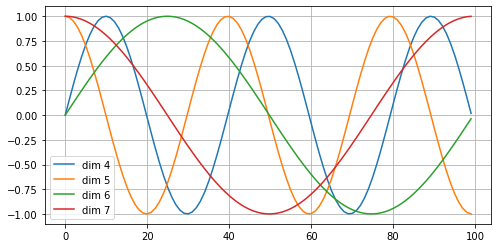

In [45]:
"""
Test the PositionalEncoding class with a toy model for 4 dimensions. 
The  4th  dimension has the same frequency as the 5th but with different offset (i.e. phase)
because one is produced by a sine function and the other is produced by a cosine function. 
The  6th  and  7th  dimensions have lower frequency.
"""
import matplotlib.pyplot as plt
import numpy as np

pe = PositionalEncoding(20, 0)
pe.eval()
Y = pe(torch.zeros((1, 100, 20))).data.cpu().numpy()  # 1 example, 100 words with embedding dim of 20
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
for p in [4, 5, 6, 7]:
    ax.plot(np.arange(100), Y[0, :, p].T, label=f'dim {p}')
ax.legend()
ax.grid()

In [46]:
# Embeddings class: sequences -> features

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size, max_position_embeddings, dropout=0):
        super().__init__()
        self.dropout = dropout
        self.word_embeddings = nn.Embedding(vocab_size, d_model, padding_idx=1)
        self.position_embeddings = PositionalEncoding(num_hiddens=d_model, dropout=self.dropout,
                                                      max_len=max_position_embeddings)

        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)
        self.d_model = d_model

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        
        # Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)                   # (bs, max_seq_length, dim)
        
        # Get position embeddings for the word embeddings and add them     
        embeddings = self.position_embeddings(word_embeddings) # (bs, max_seq_length, dim)
        
        # Layer norm 
        embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)
        return embeddings

In [47]:
# Transformer encoder

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, conv_hidden_dim, dropout=0.1):
        super().__init__()
        
        self.dropout = dropout
        self.mha = MultiHeadAttention(d_model, num_heads, dropout=dropout)
        self.cnn = CNN(d_model, conv_hidden_dim)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    
    def forward(self, x):
        
        # Multi-head attention 
        attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # Layer norm after adding the residual connection 
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        # Feed forward 
        cnn_output = self.cnn(out1)  # (batch_size, input_seq_len, d_model)
        
        # Second layer norm after adding residual connection 
        out2 = self.layernorm2(out1 + cnn_output)  # (batch_size, input_seq_len, d_model)

        return out2

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, ff_hidden_dim, input_vocab_size,
               maximum_position_encoding, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = Embeddings(d_model, input_vocab_size,maximum_position_encoding, dropout)

        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.enc_layers.append(EncoderLayer(d_model, num_heads, ff_hidden_dim, self.dropout))
        
    def forward(self, x):
        x = self.embedding(x) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # (batch_size, input_seq_len, d_model)

In [48]:
# Transormer classifier for sentiment analysis
class TransformerClassifier(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size, num_answers):
        super().__init__()
        
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
                                          maximum_position_encoding=10000)
        self.dense = nn.Linear(d_model, num_answers)

    def forward(self, x):
        x = self.encoder(x)
        x, _ = torch.max(x, dim=1)
        x = self.dense(x)
        return x

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(num_layers=1, d_model=32, num_heads=2, 
                         conv_hidden_dim=128, input_vocab_size=50002, num_answers=2)
model.to(device)

TransformerClassifier(
  (encoder): TransformerEncoder(
    (embedding): Embeddings(
      (word_embeddings): Embedding(50002, 32, padding_idx=1)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
    )
    (enc_layers): ModuleList(
      (0): EncoderLayer(
        (mha): MultiHeadAttention(
          (W_q): Linear(in_features=32, out_features=32, bias=False)
          (W_k): Linear(in_features=32, out_features=32, bias=False)
          (W_v): Linear(in_features=32, out_features=32, bias=False)
          (W_h): Linear(in_features=32, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (cnn): CNN(
          (k1convL1): Linear(in_features=32, out_features=128, bias=True)
          (k1convL2): Linear(in_features=128, out_features=32, bias=True)
          (activation): ReLU()
        )
        (layernorm1): LayerNorm((32

In [50]:
batch_size = 128
train_loader, valid_loader, test_loader = data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=batch_size, sort_key=lambda x: len(x.text), repeat=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
epochs = 10
t_total = len(train_loader) * epochs

In [51]:
def evaluate(data_loader):
    data_iterator = iter(data_loader)
    nb_batches = len(data_loader)
    model.eval()
    acc = 0 
    for batch in data_iterator:
        x = batch.text.to(device)
        y = batch.label.to(device)
                
        out = model(x)
        acc += (out.argmax(1) == y).cpu().numpy().mean()

    print(f"eval accuracy: {acc / nb_batches}")
    
    

def train(train_loader, valid_loader):
    for epoch in range(epochs):
        train_iterator, valid_iterator = iter(train_loader), iter(valid_loader)
        nb_batches_train = len(train_loader)
        train_acc = 0
        model.train()
        losses = 0.0

        for batch in train_iterator:
            x = batch.text.to(device)
            y = batch.label.to(device)
            
            out = model(x)

            loss = f.cross_entropy(out, y)
            
            model.zero_grad()

            loss.backward()
            losses += loss.item()

            optimizer.step()
                        
            train_acc += (out.argmax(1) == y).cpu().numpy().mean()
        
        print(f"epoch {epoch}: train loss: {losses / nb_batches_train}")
        print(f"training accuracy: {train_acc / nb_batches_train}")
        print('evaluating on validation:')
        evaluate(valid_loader)

In [52]:
train(train_loader, valid_loader)

Training loss at epoch 0 is 0.6815725849433378
Training accuracy: 0.5615980113636364
Evaluating on validation:
Eval accuracy: 0.6268382352941176
Training loss at epoch 1 is 0.6165380603210493
Training accuracy: 0.6621182528409091
Evaluating on validation:
Eval accuracy: 0.6940716911764706
Training loss at epoch 2 is 0.5264402922581543
Training accuracy: 0.7381285511363636
Evaluating on validation:
Eval accuracy: 0.7510110294117647
Training loss at epoch 3 is 0.45109065588225017
Training accuracy: 0.7883558238636365
Evaluating on validation:
Eval accuracy: 0.7962316176470587
Training loss at epoch 4 is 0.39714851535179396
Training accuracy: 0.8223277698863637
Evaluating on validation:
Eval accuracy: 0.7951056985294118
Training loss at epoch 5 is 0.34971896719864826
Training accuracy: 0.8463831676136363
Evaluating on validation:
Eval accuracy: 0.8150735294117647
Training loss at epoch 6 is 0.3135388213294474
Training accuracy: 0.8648650568181818
Evaluating on validation:
Eval accuracy: 0

In [53]:
evaluate(test_loader)

Eval accuracy: 0.8221699617346938


#### Transformer's Decoder Module
---
<img src="./assets/transformer_dec.png" style="height:300px">

* The Transformer decoder block looks similar to the Transformer encoder block. 
* However, besides the two sub-layers (the multi-head attention layer and the positional encoding network), the decoder Transformer block contains a third sub-layer, which applies multi-head attention on the output of the encoder stack.
* **Cross-attention**: The cross attention follows the query, key, and value setup used for the self-attention blocks. However, the inputs are a little more complicated. 
    * The input to the decoder is a data point $y_i$, which is then passed through the self attention and add norm blocks, and finally ends up at the cross-attention block. 
    * This serves as the query for cross-attention, where the key and value pairs are the output $h^{Enc}$, where this output was calculated with all past inputs $x_1, ..., x_t$.
* During training, the output for the $t$-query could observe all the previous key-value pairs. 
* It results in an different behavior from prediction. Thus, during *prediction* we can eliminate the unnecessary information by specifying the valid length to be $t$ for the $t^{th}$ query.

### <img src="https://img.icons8.com/cotton/64/000000/torch.png" style="height:50px;display:inline"> Native Transformer in PyTorch
---
* Transformer is implmented natively in PyTorch: `torch.nn.Transformer(d_model: int = 512, nhead: int = 8, num_encoder_layers: int = 6, num_decoder_layers: int = 6, dim_feedforward: int = 2048, dropout: float = 0.1, activation: str = 'relu')`
* <a href="https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html">Documentation</a>
* <a href="https://github.com/pytorch/examples/blob/master/word_language_model/main.py">Code example usage</a>

### <img src="https://img.icons8.com/plasticine/100/000000/teacher.png" style="height:50px;display:inline"> Teacher Forcing
---
* Teacher forcing is a strategy for training recurrent neural networks that uses model output from a prior time step as an input.
* Teacher forcing works by using the actual or expected output from the training dataset at the current time step $y_t$ as input in the next time step $X_{t+1}$, rather than the output generated by the network.
* This startegy allows for faster training, especially in RNNs.

## <img src="https://img.icons8.com/emoji/96/000000/woman-lifting-weights.png" style="height:50px;display:inline"> Pretrained Models - BERT and GPT
---
* Large-scale pretrained have gained popularity over the past years, as big companies can train very large models, which are then published for the public to use as-is or to use with fine-tuning for the users' custom datasets.
* **Bidirectional Encoder Representations from Transformers (BERT), Google** - a Transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google. The idea is to mask certain words and then try to predict them. The original English-language BERT model comes with two pre-trained general types:
    * (1) the $BERT_{BASE}$ model, a 12-layer, 768-hidden, 12-heads, 110M parameter neural network architecture.
    * (2) the $BERT_{LARGE}$ model, a 24-layer, 1024-hidden, 16-heads, 340M parameter neural network architecture. 
    * Both of which were trained on the BooksCorpus dataset with 800M words, and a version of the English Wikipedia with 2,500M words.
    * Extensions: RoBERTa (Facebook), DistillBERT (HuggingFace)
* **Generative Pre-trained Transformer (GPT), OpenAI** - an autoregressive language model that uses deep learning to produce human-like text. GPT was trained with a causal language modeling (CLM) objective and is therefore powerful at predicting the next token in a sequence. The proposed method utilizes generative pre-training of a language model on a diverse corpus of unlabeled text, followed by discriminative fine-tuning on each specific task. Unlike BERT, GPT is a generative model, while BERT is an effective pretrained model for embeddings of words/sentences.
    * GPT Demo - <a href="https://transformer.huggingface.co/doc/gpt">Write With Transformer</a>
* HuggingFace is a copmpany that is dedicated to publishing all of the available pretrained models and it works in PyTorch as well - <a href="https://github.com/huggingface/transformers">HuggingFace Transformers</a>
* <a href="https://pytorch.org/hub/huggingface_pytorch-transformers/">Examples with PyTorch</a>

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject

* Deep Learning for Natural Language Processing (NLP) -  <a href="https://youtu.be/6D4EWKJgNn0"> Deep Learning for Natural Language Processing (NLP) </a>
    * Attention and the Transformer <a href="https://www.youtube.com/watch?v=f01J0Dri-6k&feature=youtu.be">Practicum: Attention and the Transformer</a>

* Recurrent Neural Networks - <a href="https://www.youtube.com/watch?v=SEnXr6v2ifU"> Recurrent Neural Networks | MIT 6.S191 </a>

* LSTM & GRU - <a href="https://www.youtube.com/watch?v=8HyCNIVRbSU"> Illustrated Guide to LSTM's and GRU's: A step by step explanation </a>

* Transformers - <a href="https://www.youtube.com/watch?v=S27pHKBEp30">LSTM is dead. Long Live Transformers! </a>
* BERT - <a href="https://www.youtube.com/watch?v=OR0wfP2FD3c">BERT Explained!</a>
* GPT - <a href="https://www.youtube.com/watch?v=9ebPNEHRwXU">GPT Explained!</a>
    * GPT-3 - <a href="https://www.youtube.com/watch?v=_x9AwxfjxvE">OpenAI GPT-3 - Good At Almost Everything!</a>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* <a href="https://d2l.ai/chapter_recurrent-neural-networks/index.html">Dive Into Deep Learning - Recurrent Neural Networks</a>
* <a href="https://atcold.github.io/pytorch-Deep-Learning/en/week12/12-1/">DS-GA 1008 - NYU CENTER FOR DATA SCIENCE - Deep Sequence Modeling</a>